# Word Embedding using word2vec

## 텍스트 데이터 불러오기

In [15]:
import pandas as pd
import numpy as np
import time
import multiprocessing
import os
import re

import sys
sys.path.append("../../../../../Code Snippet/Python")
from NLP.database import view_DB_data

In [16]:
from gensim.models import word2vec

from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/Library/Fonts/NanumSquareExtraBold.ttf'
#font_path = 'C://Windows/Fonts/NanumBarunGothicBold.ttf' # for window
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['axes.facecolor']='whitesmoke'
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.options.mode.chained_assignment = None

In [4]:
# 댓글 데이터 불러오기
comments_df = view_DB_data("../DB/factcheck_news_db.db",'comments')
comments_df.head()

,comment_id,article_id,user_id,content,n_like,n_dislike,n_reply,create_time,is_bot
0,0,1601,no1k****,탈원전은 잘못된 생각 입니다. 원전이 효율면에서 아직까지 최적의 에너지입니다. 탈원...,17,3,2,2019.07.30. 01:53:59,0
1,1,1601,sanb****,"아무 연료자원 없이 100% 해외 의존해야 하고, 태양광 풍력은 투자대비 면적대비...",6,0,1,2019.07.30. 01:59:22,0
2,2,1601,choh****,한줄요약 : 문죄앙이 탈원전 때문에 나라 망함,9,4,1,2019.07.30. 01:44:58,0
3,3,1601,totu****,기자는 근본적으로 중학생의 물리학지식도 갖고있지 못하다. 간단히 이야기하자면 수소...,2,0,0,2019.07.30. 02:30:41,0
4,4,1601,sera****,이런 글 쓰기전에 고준위 핵폐기물 버리는 장소부터 물색하는게 언론의 역할 아닐까? ...,3,2,1,2019.07.30. 01:56:13,0


## 텍스트 토큰화

In [12]:
from konlpy.tag import Okt,Mecab

def tokenize_comment_okt(comment):
    okt = Okt()
    malist = okt.pos(comment, norm=True, stem=True)
    r = []

    tag_list = ['Noun', "Verb", 'Adjective', "Adverb", "Determiner", "Exclamation", "Emotion"]

    try:
        for word, tag in malist:
            if tag in tag_list:
                r.append(word)
        return r
    except Exception as e:
        print(e)
        
def tokenize_mecab(sentence):
    mecab = Mecab()
    result = [x for x in mecab.nouns(sentence) if len(x)>1]
    return result

tokenize_mecab("탈원전은 잘못된 생각 입니다. 원전이 효율면에서 아")

['원전', '생각', '원전', '효율']

In [ ]:
tokens = []
len_con = len(comments_df['content'])
for i,content in enumerate(comments_df['content']):
    print(i/len_con*100,end='\r')
    tokens.append(tokenize_mecab(content))
    
comments_df['tokens'] = tokens

In [ ]:
#comments_df.to_pickle("embedding/comment/2020-05-14_noun_over2_tokenized_comments.pkl")

In [52]:
comments_df = pd.read_pickle("embedding/comment/2020-05-14_noun_over2_tokenized_comments.pkl")

In [53]:
comments_df.head()

,comment_id,article_id,user_id,content,n_like,n_dislike,n_reply,create_time,is_bot,tokens
0,0,1601,no1k****,탈원전은 잘못된 생각 입니다. 원전이 효율면에서 아직까지 최적의 에너지입니다. 탈원...,17,3,2,2019.07.30. 01:53:59,0,"[원전, 생각, 원전, 효율, 최적, 에너지, 원전, 원전, 유지, 수소, 에너지,..."
1,1,1601,sanb****,"아무 연료자원 없이 100% 해외 의존해야 하고, 태양광 풍력은 투자대비 면적대비...",6,0,1,2019.07.30. 01:59:22,0,"[연료, 자원, 해외, 의존, 태양광, 풍력, 투자, 대비, 면적, 대비, 발전량,..."
2,2,1601,choh****,한줄요약 : 문죄앙이 탈원전 때문에 나라 망함,9,4,1,2019.07.30. 01:44:58,0,"[요약, 문죄, 원전, 때문, 나라]"
3,3,1601,totu****,기자는 근본적으로 중학생의 물리학지식도 갖고있지 못하다. 간단히 이야기하자면 수소...,2,0,0,2019.07.30. 02:30:41,0,"[기자, 근본, 중학생, 물리학, 지식, 이야기, 수소, 방법, 수소, 화학, 에너..."
4,4,1601,sera****,이런 글 쓰기전에 고준위 핵폐기물 버리는 장소부터 물색하는게 언론의 역할 아닐까? ...,3,2,1,2019.07.30. 01:56:13,0,"[고준, 핵폐기물, 장소, 물색, 언론, 역할, 발전소, 폐기물, 후면, 원전, 대..."


## word2vec 구축

In [56]:
from gensim.models import word2vec

config = {
    'window' : 5,
    'min_count': 5,  # 등장 횟수가 5 이하인 단어는 무시
    'size': 150,  # 150차원짜리 벡터스페이스에 embedding
    'sg': 1,  # 0이면 CBOW, 1이면 skip-gram을 사용한다
    'batch_words': 10000,  # 사전을 구축할때 한번에 읽을 단어 수
    'iter': 30,  # 보통 딥러닝에서 말하는 epoch과 비슷한, 반복 횟수
    'workers': multiprocessing.cpu_count(),
}

# 모델 학습
w2v_model = word2vec.Word2Vec(comments_df['tokens'],**config) # Word2vec 모델 생성

In [57]:
# 모델 저장
w2v_model.save('embedding/model/0520_noun_w2vmodel') # 모델을 'model' 파일에 저장

In [14]:
w2v_path = 'embedding/model/0520_noun_w2vmodel'

def load_word2vec(w2v_path):
    # word2vec 모델 불러오기
    start = time.time()
    print("word2vec 모델 불러오기 ... ", end="", flush=True)
    w2v_model = word2vec.Word2Vec.load(w2v_path)
    print("finished in {:.2f} sec.".format(time.time() - start), flush=True)
    
    # 벡터 노말라이즈 해서 용량 대폭 감소시킴
    w2v_model.wv.init_sims(replace=True) 
    
    # about model
    word_vectors = w2v_model.wv.vectors
    word_idxs = w2v_model.wv.index2word
    n_words = word_vectors.shape[0]
    vec_size = word_vectors.shape[1]
    print("#words = {0}, vector size = {1}".format(n_words, vec_size))
    
    return w2v_model

In [61]:
w2v_model = load_word2vec(w2v_path)

word2vec 모델 불러오기 ... finished in 0.24 sec.
#words = 23179, vector size = 150


In [72]:
# 연관성 테스트
w2v_model.wv.most_similar("중국")

[('짱깨', 0.7045726776123047),
 ('우륵', 0.5892908573150635),
 ('미세먼지', 0.5862813591957092),
 ('요충지', 0.5609233379364014),
 ('스모그', 0.5561639070510864),
 ('발미', 0.538915753364563),
 ('짱꼴라', 0.5332441329956055),
 ('황해', 0.5330190658569336),
 ('시진핑', 0.5320504307746887),
 ('북서풍', 0.5307453274726868)]

## MiniBatchKMeans Clustering
- 참고 : https://github.com/gaetangate/word2vec-cluster/blob/master/word2vec_cluster.py

- 차원 축소 
    - 단어 벡터 차원이 100차원 이상이므로 고차원 데이터. (관련 연구에 의하면 word2vec은 150-300 차원으로 구축할 때 대체로 성능이 좋다고 한다. 그 이상일 경우 성능 오히려 하락한다고 함.) 이러한 고차원 데이터 몇 만개를 바로 군집화하면 시간이 오래 걸리기에 pca로 차원을 50차원으로 줄인 뒤에 군집화하였다. 
    

- MiniBatchKmeans

    - Kmeans 와 비교하여 성능 차이는 얼마 나지 않지만 그 속도가 배로 빠르다. Kmeans 알고리즘으로 군집을 돌리면 노트북 팬이 나갈 수 있음

In [62]:
def cluster_word2vec(k):

    # load word2vec
    w2v_model = load_word2vec(w2v_path)
    # get vector and word pairs
    word_vectors = w2v_model.wv.vectors
    word_idxs = w2v_model.wv.index2word
    
    # Discard data of less than 1 length.
    wordvec_df = pd.DataFrame(data={"vects": [x for x in word_vectors],
                                    "word": word_idxs,
                                    "word_len": [len(i) for i in word_idxs]})
    wordvec_df = wordvec_df[wordvec_df.word_len > 1].reset_index(drop=True)
    new_word_vectors = np.vstack(wordvec_df['vects'])
    new_word_idxs = wordvec_df['word'].tolist()
    
    # Dimension Reduction
    pca = PCA(n_components = 50)
    pca_vectors = pca.fit_transform(new_word_vectors)
    
    # replace values
    wordvec_df['vects'] = [x for x in pca_vectors]
    
    # clustering
    start = time.time()
    print("Compute clustering ... ", end="", flush=True)
    
    mbk_means = MiniBatchKMeans(n_clusters=k,
                               n_init = 10,
                               batch_size=100,
                               max_iter= 100,
                               random_state=0,
                               init_size = 500,
                               max_no_improvement=10000,
                               verbose=False)
    clusters = mbk_means.fit_predict(pca_vectors)
    print("finished in {:.2f} sec.".format(time.time() - start), flush=True)

    wordvec_df['cluster'] = clusters
    for i in range(k):
        print("군집 {}".format(i), end = ' : ')
        print(wordvec_df[wordvec_df.cluster == i]['word'][:30].tolist(),end='')
        print("\n")
        
    return wordvec_df

In [64]:
wordvec_df = cluster_word2vec(30)

word2vec 모델 불러오기 ... finished in 0.24 sec.
#words = 23179, vector size = 150
Compute clustering ... finished in 26.57 sec.
군집 0 : ['교수', '교육', '특혜', '학교', '공부', '채용', '취업', '대학', '서울대', '공기업', '논문', '합격', '학생', '의사', '귀걸이', '전문', '선생', '교사', '평가', '연구', '시험', '병설', '실력', '법대', '영어', '초등', '준용', '이력서', '분야', '휴교']

군집 1 : ['조사', '박근혜', '검찰', '누구', '탄핵', '사건', '수사', '불법', '비리', '노무현', '경찰', '구속', '유공자', '이명박', '사형', '특검', '판사', '판결', '검사', '최순', '행위', '국정', '감옥', '징역', '자살', '이명', '뇌물', '무죄', '정유라', '변호사']

군집 2 : ['사람', '생각', '대통령', '세상', '당신', '현실', '촛불', '텐데', '걱정', '능력', '그때', '언제', '미래', '겁니다', '당장', '마음', '대책', '준비', '관심', '나중', '자국민', '포기', '기회', '신경', '하늘', '노력', '선택', '여러분', '도움', '진심']

군집 3 : ['난민', '여자', '사회', '처벌', '인권', '남자', '범죄', '여성', '피해자', '범죄자', '강간', '살인', '결혼', '문화', '보호', '거세', '화학', '치료', '성범죄', '음주운전', '성폭행', '남성', '물리', '폭력', '추방', '이중', '장애', '낙태', '혐오', '가해자']

군집 4 : ['시간', '거기', '하루', '집회', '동네', '시위', '축제', '거리', '인원', '단속', '광화문', '현장', '저기', '서리', '아침', '

In [65]:
print("군집 당 단어 분포")
pd.DataFrame(wordvec_df.groupby("cluster")['word'].count().describe())

군집 당 단어 분포


,word
count,30.000000
mean,772.633333
std,214.009907
min,55.000000
25%,679.500000
50%,769.000000
75%,859.250000
max,1327.000000


In [74]:
wordvec_df.head()

,vects,word,word_len,cluster
0,"[-0.17513373, -0.20824242, -0.07527731, 0.1348...",국민,2,5
1,"[-0.09262645, -0.20026334, 0.19445305, 0.22463...",나라,2,8
2,"[0.0075419843, 0.08177854, -0.1132697, 0.07386...",사람,2,2
3,"[0.059308697, -0.2033102, 0.30899987, 0.089618...",우리,2,25
4,"[0.022286007, -0.060473576, -0.10517109, 0.186...",생각,2,2


## Visualize clustering results

- 고차원 데이터 시각화 알고리즘인 TSNE 이용
- 시각화 속도가 매-우 오래걸리기에 pca로 차원을 축소한 뒤 알고리즘을 돌린다.
- 단어가 1000개 이상일 경우 군집 정도가 잘 보이지 않음. 단어를 5000개 이상으로 늘릴 경우 까만색 원 그림이 나온다..
- word2vec에서 단어가 실제로 이렇게 묶여있구나 파악하기에 좋음.
- 이쁘다
- 있어 보인다

In [84]:
def visualize_cluster_results(wordvec_df, n_samples):

    new_wordvec_df = pd.DataFrame()
    for i in range(len(set(wordvec_df.cluster))):
        new_wordvec_df = new_wordvec_df.append(wordvec_df[wordvec_df.cluster == i][:n_samples])
    new_wordvec_df = new_wordvec_df.reset_index(drop=True)
    
    tokens = np.vstack(new_wordvec_df['vects'])
    words = new_wordvec_df['word'].tolist()
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23,verbose=1)
    tsne_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in tsne_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.003s...
[t-SNE] Computed neighbors for 600 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.266437
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.993797
[t-SNE] KL divergence after 2500 iterations: 1.293007


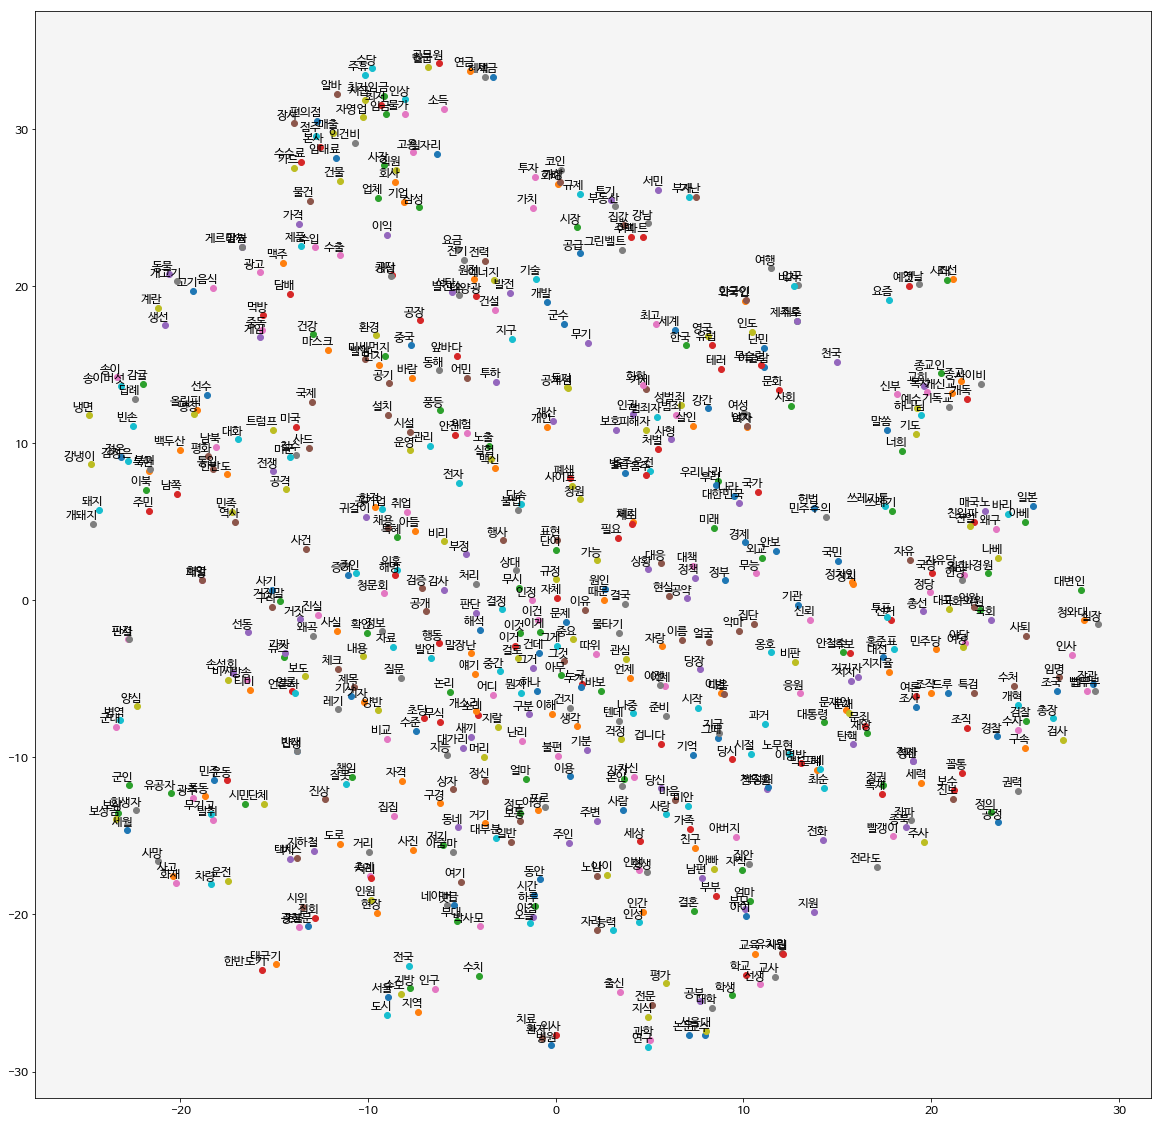

In [85]:
visualize_cluster_results(wordvec_df, 20)

# Visualize word2vec

- 위에서는 클러스터링을 한 뒤에 시각화를 돌렸다.
- 이번에는 그냥 곧바로 word2vec 모델 받은 뒤에 시각화 돌리기
- 파라미터 N으로 뽑을 단어 수를 정한다.

In [13]:
def tsne_plot(model, N):
    "Create TSNE model and plot it"
    
    tokens = w2v_model.wv.vectors[:N]
    words = w2v_model.wv.index2word[:N]
    
    # cut word length under 1
    wordvec_df = pd.DataFrame(data={"vects":[x for x in tokens],
                                  "word":words,
                                  "word_len":[len(i) for i in words]})
    wordvec_df = wordvec_df[wordvec_df.word_len > 1].reset_index(drop=True)
    
    new_tokens = np.vstack(wordvec_df['vects'])
    new_words = wordvec_df['word'].tolist()
    
    pca = PCA(n_components = 50)
    pca_tokens = pca.fit_transform(new_tokens)
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23,verbose=1)
    tsne_values = tsne_model.fit_transform(pca_tokens)
    
    x = []
    y = []
    
    for value in tsne_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(new_words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model, 500)

NameError: name 'w2v_model' is not defined